**Installing Necessary Libraries:**

In [ ]:
!pip install transformers
!pip install torch
!pip install scikit-learn

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

**Loading Data & Preprocessing:**

Converting Numerical Data to Textual Data

In [ ]:
def create_text(row):
    sex = "male" if row['Sex'] == 1 else "female"
    angina = "experiences exercise-induced angina" if row['ExerciseAngina'] == 1 else "does not experience exercise-induced angina"
    fasting_bs = "has high fasting blood sugar" if row['FastingBS'] == 1 else "has normal fasting blood sugar"

    return (
        f"The patient is a {row['Age']}-year-old {sex} with a resting blood pressure of {row['RestingBP']} mmHg "
        f"and a cholesterol level of {row['Cholesterol']} mg/dL. The patient reports {row['ChestPainType']} chest pain. "
        f"The fasting blood sugar {fasting_bs}, and the resting ECG shows {row['RestingECG']}. "
        f"The maximum heart rate achieved is {row['MaxHR']} bpm, and the patient {angina}. "
        f"The ST segment shows a change of {row['Oldpeak']} with an ST slope categorized as {row['ST_Slope']}."
    )

In [ ]:
import pandas as pd

# Loading the Dataset
df = pd.read_csv("/content/drive/MyDrive/NLP/Classification Using LLMs/Heart Disease/heart.csv")

# Creating a New Text Column
df['text'] = df.apply(create_text, axis=1)

# Saving Textual Data to a New CSV File
file_path = "/content/drive/MyDrive/NLP/Classification Using LLMs/Heart Disease/heart_disease_text.csv"
df[['text', 'HeartDisease']].to_csv(file_path, index=False)

# Displaying a Sample of Textual Data
print(df[['text', 'HeartDisease']].head())

                                                text  HeartDisease
0  The patient is a 40-year-old female with a res...             0
1  The patient is a 49-year-old female with a res...             1
2  The patient is a 37-year-old female with a res...             0
3  The patient is a 48-year-old female with a res...             1
4  The patient is a 54-year-old female with a res...             0


In [ ]:
from sklearn.model_selection import train_test_split

data = pd.read_csv("/content/drive/MyDrive/NLP/Classification Using LLMs/Heart Disease/heart_disease_text.csv")

# Splitting the Data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['text'], data['HeartDisease'], test_size=0.3, random_state=42
)

**Model - BERT & DistilBERT**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Loading DistilBERT
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Loading BERT
#tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
#model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Loading BioBERT
#tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
#model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.1", num_labels=2)

# Loading ClinicalBERT
#tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
#model = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenizing Training Data
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128, return_tensors="pt")

# Tokenizing Testing Data
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128, return_tensors="pt")


In [ ]:
from torch.utils.data import Dataset

class HeartDiseaseDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Creating Dataset for training and evaluation data
train_dataset = HeartDiseaseDataset(train_encodings, train_labels.tolist())
val_dataset = HeartDiseaseDataset(val_encodings, val_labels.tolist())


In [ ]:
from torch.utils.data import DataLoader

# DataLoader for training and evaluation
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torch.optim import AdamW

# Setting the Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Number of Epochs
epochs = 10

# Training Loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        # Transferring data to GPU/CPU
        model.to(device)
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)
        labels = labels.type(torch.LongTensor).to(device)

        # Calculating predictions and loss
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss

        # Backpropagation and weight update
        loss.backward()
        optimizer.step()

        # Recording the loss value
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")


Epoch 1/10, Loss: 0.5499942755257642
Epoch 2/10, Loss: 0.4347181443446948
Epoch 3/10, Loss: 0.44786307252483604
Epoch 4/10, Loss: 0.4433324075775382
Epoch 5/10, Loss: 0.42974960187703004
Epoch 6/10, Loss: 0.4053783725809168
Epoch 7/10, Loss: 0.3971295882890254
Epoch 8/10, Loss: 0.39165146041799476
Epoch 9/10, Loss: 0.35749363752058994
Epoch 10/10, Loss: 0.39297258642352656


**Evaluation & Results:**

Accuracy: 0.8007246376811594
Precision: 0.9291338582677166
Recall: 0.7195121951219512
F1-Score: 0.8109965635738832
AUC-ROC: 0.9228005226480837


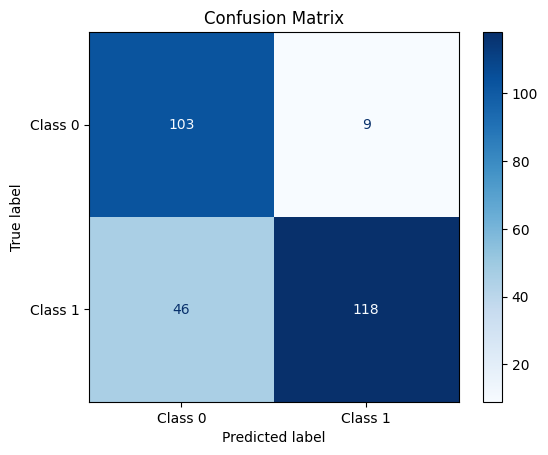

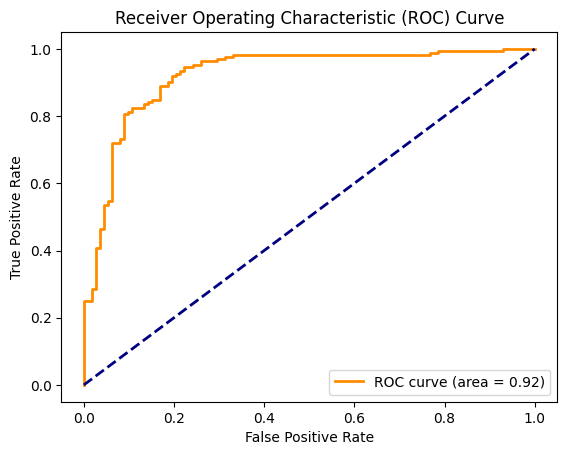

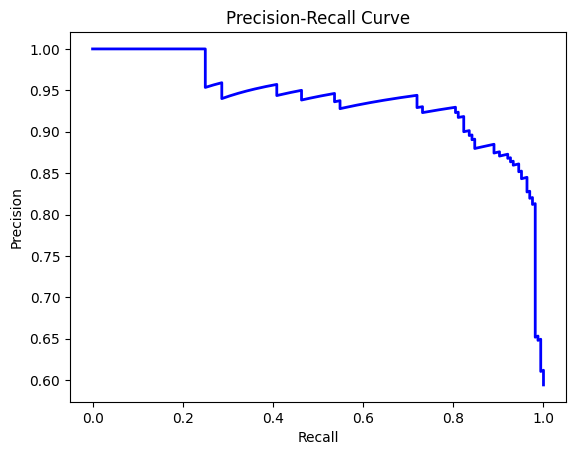

In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Make predictions and collect probabilities for ROC curve
model.eval()
total_eval_loss = 0
predictions, true_labels = [], []
probs = []  # For collecting probabilities

with torch.no_grad():
    for batch in val_loader:
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        # Prediction
        outputs = model(**inputs, labels=labels)
        logits = outputs.logits

        # Calculating probabilities
        batch_probs = torch.softmax(logits, dim=-1)[:, 1].tolist()  # احتمال کلاس مثبت
        probs.extend(batch_probs)

        # Collecting predictions and labels
        predictions.extend(torch.argmax(logits, dim=-1).tolist())
        true_labels.extend(labels.tolist())

# Calculating evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
roc_auc = roc_auc_score(true_labels, probs)

# Displaying results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC-ROC: {roc_auc}")

# Generate Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(true_labels, probs)
roc_auc_value = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

precision_vals, recall_vals, _ = precision_recall_curve(true_labels, probs)

plt.figure()
plt.plot(recall_vals, precision_vals, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
